<a href="https://colab.research.google.com/github/AdityaMVerma/AdityaMVerma/blob/main/ML_DS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

DATA LOADING

In [66]:
data = pd.read_csv("traffic.csv")
data.head()

,DateTime,Junction,Vehicles,ID
0,01-11-2015 00:00,1,15,20151101001
1,01-11-2015 01:00,1,13,20151101011
2,01-11-2015 02:00,1,10,20151101021
3,01-11-2015 03:00,1,7,20151101031
4,01-11-2015 04:00,1,9,20151101041


DATA EXPLORATION

DROPPING THE COLUMN OF ID AS IT IS UNNECESSARY.

In [67]:
data["DateTime"]= pd.to_datetime(data["DateTime"], errors='coerce', format='%d-%m-%Y %H:%M')

data = data.drop(["ID"], axis=1) #dropping IDs
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


PLOTTING TIME SERIES OF THE REMAINING DATA

Text(0.5, 0, 'Date')

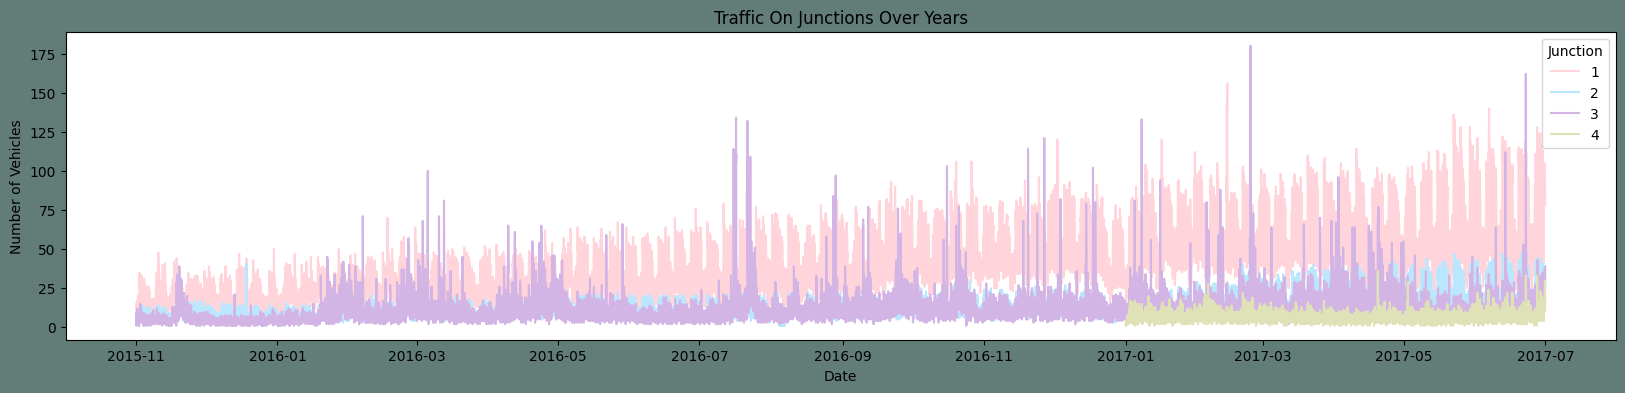

In [68]:
df=data.copy()
#Let's plot the Timeseries
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
plt.figure(figsize=(20,4),facecolor="#627D78")
Time_series=sns.lineplot(x=df['DateTime'],y="Vehicles",data=df, hue="Junction", palette=colors)
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")

KEY TAKEAWAYS :

It can be seen here that the first junction is visibly having an upward trend.

The data for the fourth junction is sparse starting only after 2017.

Seasonality is not evident from the above plot, So we must explore datetime composition to figure out more about it.

EXPLORATORY DATA ANALYSIS  AND FEATURE ENGINEERING OF THE TIME


In [69]:
df["Year"]= df['DateTime'].dt.year
df["Month"]= df['DateTime'].dt.month
df["Date_no"]= df['DateTime'].dt.day
df["Hour"]= df['DateTime'].dt.hour
df["Day"]= df.DateTime.dt.strftime("%A")
df.head()

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


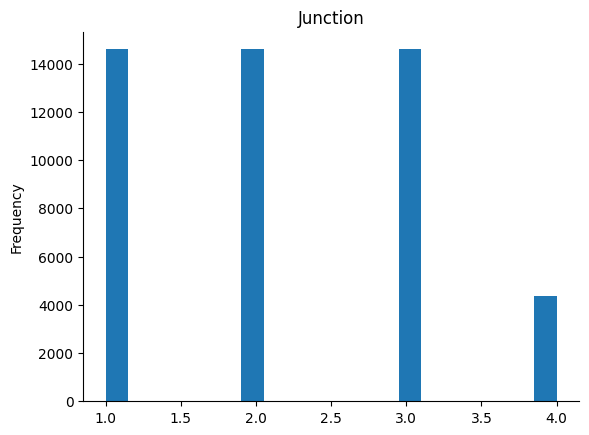

In [70]:
# @title Junction

from matplotlib import pyplot as plt
df['Junction'].plot(kind='hist', bins=20, title='Junction')
plt.gca().spines[['top', 'right',]].set_visible(False)

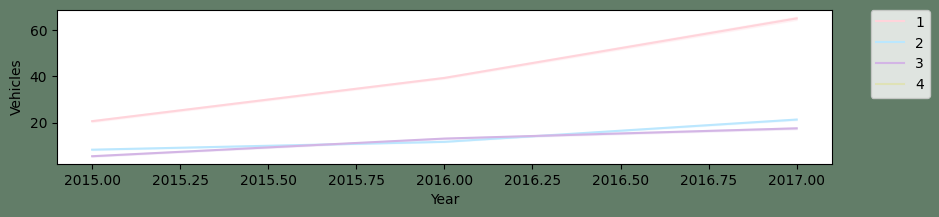

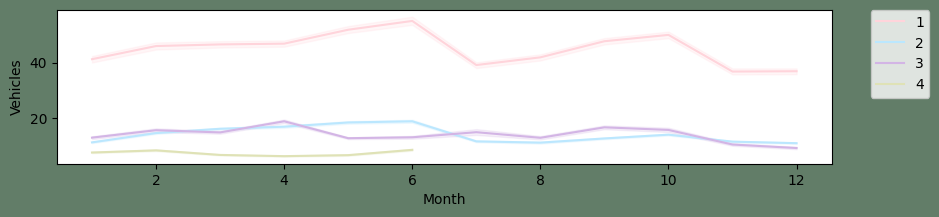

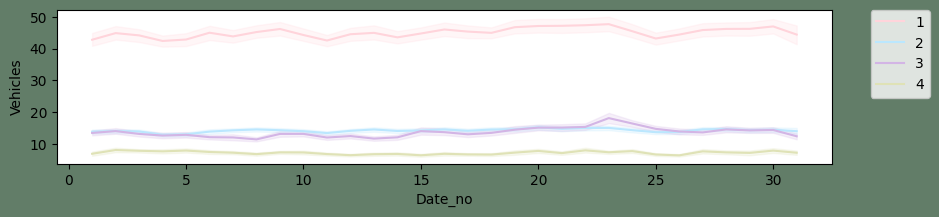

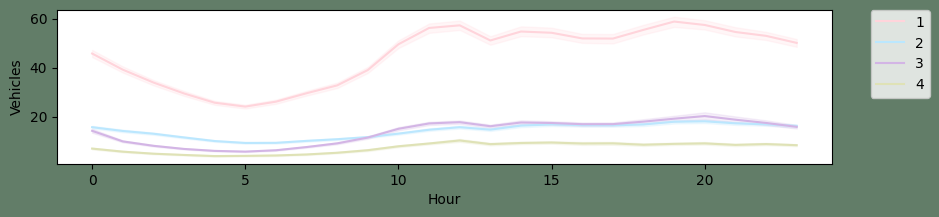

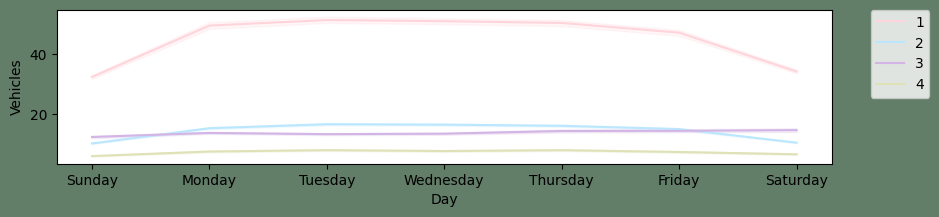

In [71]:
#Let's plot the Timeseries
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]

for i in new_features:
    plt.figure(figsize=(10,2),facecolor="#627D68")
    ax=sns.lineplot(x=df[i],y="Vehicles",data=df, hue="Junction", palette=colors )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Key takeaways:
Yearly, there has been an upward trend for all junctions except for the fourth junction. As we already established above that the fourth junction has limited data and that don't span over a year.

We can see that there is an increase in the first and second junctions around June this might be due to summer break and activities around the same.

Weekly data Sunday has less traffic and smoother tha usual unlike Monday-Friday (the workweek)


In [ ]:
sns.pairplot(data=df, hue= "Junction",palette=colors)

In [ ]:
plt.figure(figsize=(12,5),facecolor="#627D78")
count = sns.countplot(data=df, x =df["Year"], hue="Junction", palette=colors)
count.set_title("Count Of Traffic On Junctions Over Years")
count.set_ylabel("Number of Vehicles")
count.set_xlabel("Date")

In [ ]:
df.info()

In [ ]:
# Exclude 'DateTime' column
df_numeric = df.drop(columns=['DateTime'])

# Convert non-numeric values to NaN and calculate correlation matrix
corrmat = df_numeric.apply(pd.to_numeric, errors='coerce').corr()

# Plot heatmap
plt.subplots(figsize=(10, 10), facecolor="#7F3ABD")
sns.heatmap(corrmat, cmap="Pastel2", annot=True, square=True)
plt.show()

CORRELATION MATRIX :

A value closer to 1 indicates a strong positive correlation. For instance, the correlation between junctions and vehicles (0.61) is positive, which means that there is a tendency for the number of vehicles to increase as the number of junctions increases, which is intuitive as more junctions likely means more roads and potentially higher traffic volume.

A value closer to -1 indicates a strong negative correlation. In the matrix, there is a weak negative correlation between year and junctions (-0.076). It's difficult to say for sure what this means without more data, but it could be that newer areas have fewer junctions.

A value closer to 0 indicates a weak or no correlation. For example, there is a weak negative correlation between month and junctions (-0.017). This means there is not a strong relationship between the number of junctions and a specific month.


The yearly trend for Junctions one, two and three have diffrent slopes.

Junction number one has a more strong weekly seasonality in comparison to the other junctions.

In [ ]:
#Augmented Dickey Fuller Test:
#Testing for Stationarity: Confirm whether the  time series data is stationary.
#Modeling Time Series: Before fitting a time series model, such as ARIMA (AutoRegressive Integrated Moving Average), we should check the stationarity of the data as it is a key assumption in ARIMA model

Dividing up the data into different Junnctions

In [ ]:
df_J = data.pivot(columns="Junction", index="DateTime")
df_J.describe()

In [ ]:
df_1 = df_J[[('Vehicles', 1)]]
df_2 = df_J[[('Vehicles', 2)]]
df_3 = df_J[[('Vehicles', 3)]]
df_4 = df_J[[('Vehicles', 4)]]
df_4 = df_4.dropna() #Junction 4 has limited data of 2017

#Dropping level one in dfs's index as it is a multi index data frame
list_dfs = [df_1, df_2, df_3, df_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)

def Sub_Plots4(df_1, df_2,df_3,df_4,title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8),facecolor="#7F3ABD", sharey=True)
    fig.suptitle(title)
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[0])
    #pl_1=plt.ylabel()
    axes[0].set(ylabel ="Junction 1")
    #J2
    pl_2=sns.lineplot(ax=axes[1],data=df_2,color=colors[1])
    axes[1].set(ylabel ="Junction 2")
    #J3
    pl_3=sns.lineplot(ax=axes[2],data=df_3,color=colors[2])
    axes[2].set(ylabel ="Junction 3")
    #J4
    pl_4=sns.lineplot(ax=axes[3],data=df_4,color=colors[3])
    axes[3].set(ylabel ="Junction 4")

Sub_Plots4(df_1.Vehicles, df_2.Vehicles,df_3.Vehicles,df_4.Vehicles,"Dataframes Before Transformation")

Normalization of the data and then Differences to reduce seasonality of the junction 1 and 2

In [ ]:
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In [19]:
df_N1, av_J1, std_J1 = Normalize(df_1, "Vehicles")
Diff_1 = Difference(df_N1, col="Vehicles", interval=(1)) #taking a hours diffrence
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1

df_N2, av_J2, std_J2 = Normalize(df_2, "Vehicles")
Diff_2 = Difference(df_N2, col="Vehicles", interval=(1)) #taking a hours diffrence
df_N2 = df_N2[24:]
df_N2.columns = ["Norm"]
df_N2["Diff"]= Diff_2

df_N3, av_J3, std_J3 = Normalize(df_3, "Vehicles")
Diff_3 = Difference(df_N3, col="Vehicles", interval=1) #taking an hour's diffrence
df_N3 = df_N3[1:]
df_N3.columns = ["Norm"]
df_N3["Diff"]= Diff_3

df_N4, av_J4, std_J4 = Normalize(df_4, "Vehicles")
Diff_4 = Difference(df_N4, col="Vehicles", interval=1) #taking an hour's diffrence
df_N4 = df_N4[1:]
df_N4.columns = ["Norm"]
df_N4["Diff"]= Diff_4

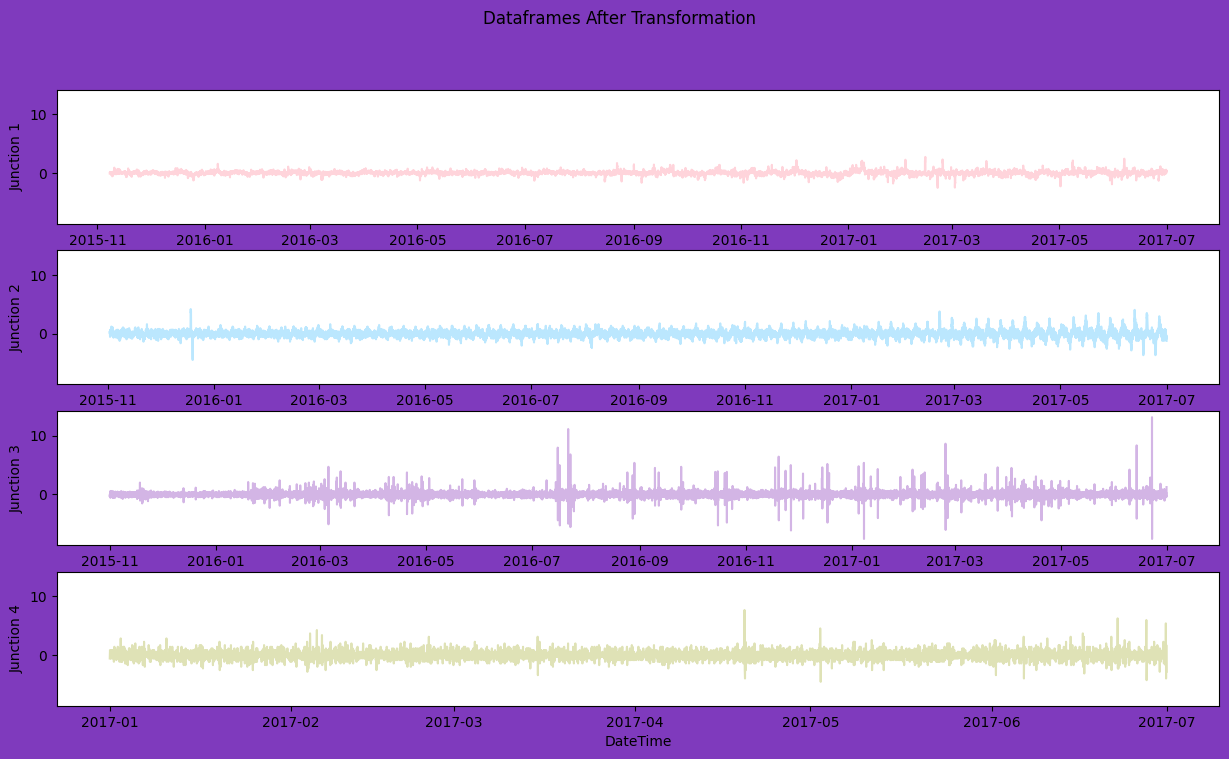

In [20]:
Sub_Plots4(df_N1.Diff, df_N2.Diff,df_N3.Diff,df_N4.Diff,"Dataframes After Transformation")

DICKY FULLER TEST


In [21]:
def Stationary_check(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary")


#Checking if the series is stationary

List_df_ND = [ df_N1["Diff"], df_N2["Diff"], df_N3["Diff"], df_N4["Diff"]]
print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

Checking the transformed series for stationarity:


ADF Statistic: -15.265303390415337
p-value: 4.79853987639816e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -21.795891026940065
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -28.001759908832316
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.979092563052276
p-value: 2.778787532595421e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


 (PACF )  & ACF TEST TO FIND POSSIBLE VALUE OF P,D,Q BUT CAN ALSO USE AUTO ARIMA FUNCTION WHICH NECESSARILY DOESNOT GIVE THE BEST OUTCOME BUT GIVES A GOOD OUTCOME. WRT TO OTHER OUTCOMES AND REDUCE AIC and BIC VALUES.
 Look for the first lag where the partial autocorrelation value falls outside the confidence intervals and then cuts off afterwards. This lag (let's say it's k) is considered a good starting point for the p parameter in your ARIMA model.
In the provided image, the first significant lag seems to be at lag 5. So, a p value of 5 could be a good starting point for your model.

In [54]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.6 MB/s eta 0:00:00


In [47]:
from pmdarima import auto_arima
arima_model = auto_arima(df_N1['Diff'], seasonal=True)
print(arima_model.summary())
arima_model = auto_arima(df_N2['Diff'], seasonal=True)
print(arima_model.summary())
arima_model = auto_arima(df_N3['Diff'], seasonal=True)
print(arima_model.summary())
arima_model = auto_arima(df_N4['Diff'], seasonal=True)
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                14424
Model:               SARIMAX(2, 0, 1)   Log Likelihood                2027.019
Date:                Fri, 19 Apr 2024   AIC                          -4044.038
Time:                        10:39:25   BIC                          -4006.154
Sample:                    11-08-2015   HQIC                         -4031.444
                         - 06-30-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0021      0.001      2.505      0.012       0.000       0.004
ar.L1          1.0601      0.020     53.855      0.000       1.022       1.099
ar.L2         -0.1332      0.016     -8.465      0.0

# P,D,Q=
# P,D,Q=
# P,D,Q=
# P,D,Q=


In [56]:
df_N1.describe()

,Norm,Diff
count,14424.000000,14424.000000
mean,0.013345,0.028011
std,0.997594,0.318385
min,-1.740799,-2.520824
25%,-0.741162,-0.130387
50%,-0.176149,0.043462
75%,0.606175,0.173850
max,4.822037,2.738137


In [57]:
#df_N1
from statsmodels.tsa.arima.model import ARIMA

# Fit your ARIMA model (replace with your actual code)
model = ARIMA(df_N1['Diff'], order=(2, 0, 1))
model_fit = model.fit()

# Forecast for a specific period (replace with your desired forecast horizon)
forecast = model_fit.forecast(steps=14424)

# Calculate RMSE using actual values (replace with your actual data)
rmse = np.sqrt(mean_squared_error(df_N1['Diff'][-14424:], forecast))  # Assuming the last 10 values are actuals
print(f"RMSE: {rmse}")
print(forecast)

RMSE: 0.31840638377651975
2017-07-01 00:00:00    0.192351
2017-07-01 01:00:00    0.188590
2017-07-01 02:00:00    0.176362
2017-07-01 03:00:00    0.163902
2017-07-01 04:00:00    0.152322
                         ...   
2019-02-21 19:00:00    0.028126
2019-02-21 20:00:00    0.028126
2019-02-21 21:00:00    0.028126
2019-02-21 22:00:00    0.028126
2019-02-21 23:00:00    0.028126
Freq: H, Name: predicted_mean, Length: 14424, dtype: float64


In [63]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

# Load/prepare your data (replace with your code)

# Split data into training and validation sets (consider a validation size of 20-30%)
train, validation = train_test_split(df_N1['Diff'], test_size=0.25,random_state=56)

# Fit ARIMA model on the training set
model = ARIMA(train, order=(2, 0, 1))  # Replace (p, d, q) with your parameters
model_fit = model.fit()

# Make predictions on the validation set
forecast = model_fit.forecast(steps=len(validation))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(validation, forecast))
print("THE FORECAST FOR JUNCTION 1 IS AS FOLLOWS ")
print(forecast.values)
print(f"RMSE on validation set: {rmse}")


THE FORECAST FOR JUNCTION 1 IS AS FOLLOWS 
[44.76994845 45.3446833  44.88449051 ... 45.03499585 45.03499585
 45.03499585]
RMSE on validation set: 22.980638399416957


In [64]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

# Load/prepare your data (replace with your code)

# Split data into training and validation sets (consider a validation size of 20-30%)
train, validation = train_test_split(df_N2['Diff'], test_size=0.2,random_state=42)

# Fit ARIMA model on the training set
model = ARIMA(train, order=(3, 0, 2))  # Replace (p, d, q) with your parameters
model_fit = model.fit()

# Make predictions on the validation set
forecast = model_fit.forecast(steps=len(validation))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(validation, forecast))
print("THE FORECAST FOR JUNCTION 2 IS AS FOLLOWS ")
print(forecast)
print(f"RMSE on validation set: {rmse}")



THE FORECAST FOR JUNCTION 2 IS AS FOLLOWS 
11654    0.001090
11655   -0.011249
11656    0.012087
11657    0.010006
11658    0.007325
           ...   
14563    0.008758
14564    0.008758
14565    0.008758
14566    0.008758
14567    0.008758
Name: predicted_mean, Length: 2914, dtype: float64
RMSE on validation set: 0.6131176080375513


In [50]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

# Load/prepare your data (replace with your code)

# Split data into training and validation sets (consider a validation size of 20-30%)
train, validation = train_test_split(df_N3['Diff'], test_size=0.2,random_state=42)

# Fit ARIMA model on the training set
model = ARIMA(train, order=(5, 0, 3))  # Replace (p, d, q) with your parameters
model_fit = model.fit()

# Make predictions on the validation set
forecast = model_fit.forecast(steps=len(validation))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(validation, forecast))
print("THE FORECAST FOR JUNCTION 3 IS AS FOLLOWS ")
print(forecast)
print(f"RMSE on validation set: {rmse}")


THE FORECAST FOR JUNCTION 3 IS AS FOLLOWS 
11672    0.006713
11673    0.000079
11674    0.000573
11675    0.007224
11676    0.007793
           ...   
14586    0.001798
14587    0.001798
14588    0.001798
14589    0.001798
14590    0.001798
Name: predicted_mean, Length: 2919, dtype: float64
RMSE on validation set: 0.5238274625152519
